## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [68]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf

from cv2 import imread

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [69]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
%cd /content/gdrive/MyDrive/Bootcamp/Ejercicios/Sprint_16/Unidad_1/Challenge

/content/gdrive/MyDrive/Bootcamp/Ejercicios/Sprint_16/Unidad_1/Challenge


### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras.



### **Función para leer train y test**

In [71]:
ROOT_PATH = './data/'
TRAIN_PATH_0 = ROOT_PATH + "github_train_0"
TRAIN_PATH_1 = ROOT_PATH + "github_train_1"
TRAIN_PATH_2 = ROOT_PATH + "github_train_2"
TRAIN_PATH_3 = ROOT_PATH + "github_train_3"
TEST_PATH = ROOT_PATH + "github_test"

In [72]:
def read_data(directorios, reshape_dim = (32,32)):
    X = []
    y = []
    for directorio in directorios:
        if os.path.isdir(directorio):
            for file in os.listdir(directorio):
                image = imread('/'.join([directorio, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(file.split(".")[0])

    return np.array(X),np.array(y)

In [73]:
X_train, y_train = read_data([TRAIN_PATH_0, TRAIN_PATH_1, TRAIN_PATH_2, TRAIN_PATH_3])

In [74]:
X_test, y_test = read_data([TEST_PATH])

In [75]:
y_train_series = pd.Series(y_train)

In [76]:
y_train_series.unique()

array(['cat', 'dog'], dtype=object)

In [77]:
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

In [78]:
y_train = (y_train == "cat").astype(int)
y_test = (y_test == "cat").astype(int)

### **Visualización de target y de imágenes**

In [79]:
y_train_series.value_counts()

,count
cat,2000
dog,2000


In [80]:
pd.Series(y_train).value_counts()

,count
1,2000
0,2000


El target está completamente equilibrado

In [81]:
class_names = ["dog", "cat"]
def show_images_batch(pets, n_cols, labels = [], names = class_names):
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    for index, cloth in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cloth, cmap = "Greys")
        plt.axis("off")
        if len(labels):
            plt.title(names[labels[index]])

In [121]:
X_train, y_train = shuffle(X_train, y_train)

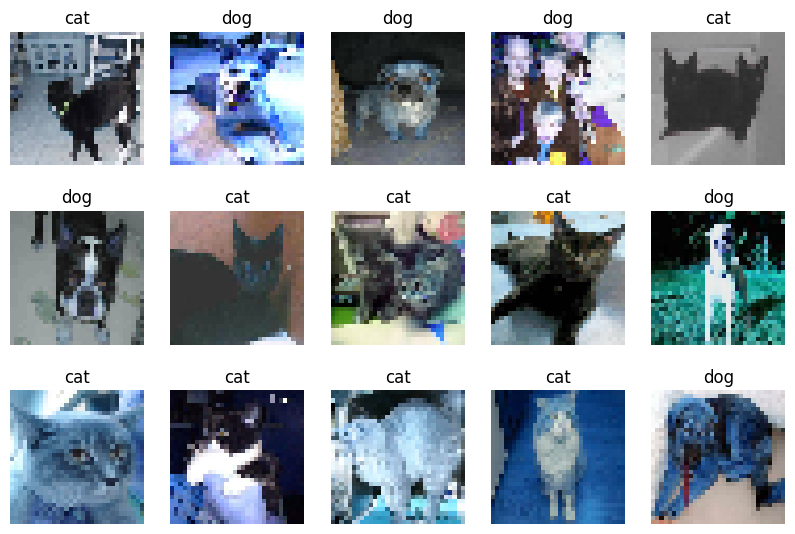

In [122]:
show_images_batch(X_train[:15], 5, y_train[:15])

Las imágenes se han cargado adecuadamente, aunque espero que el modelo las distinga mejor que yo, porque con esta definición en algunas no estoy muy seguro.

### **Construcción del modelo**

In [84]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 30, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 15, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(400, activation="relu"),

     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Dense(200, activation= "relu"),
     tf.keras.layers.Dense(100, activation= "relu"),
     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilado

In [85]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [86]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 30)     │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 400)            │       384,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,146 (1.87 MB)

 Trainable params: 491,146 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [87]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.4843 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.5077 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 471ms/step - accuracy: 0.4926 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5193 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5115 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5097 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.5134 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.5099 - loss: nan - val_accuracy: 0.4900 - val_loss: nan
E

KeyboardInterrupt: 

In [ ]:
pd.Series(y_train).unique()

Funciona muy mal, no mejora nada, voy a probar poniendo menos filtros en la primera capa y más en la segunda.

In [ ]:
capas = [
    tf.keras.layers.Input(shape = (X_train[0].shape)),
    tf.keras.layers.Conv2D(filters = 40, kernel_size = (3,3), padding= "same",
                            activation = "relu" ),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(400, activation="relu"),

    #  tf.keras.layers.Dropout(0.5),

    #  tf.keras.layers.Dense(200, activation= "relu"),
     tf.keras.layers.Dense(100, activation= "relu"),
     tf.keras.layers.Dense(1, activation = "sigmoid")]

model_2 = tf.keras.Sequential(capas)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_2.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_2.summary()

### **Entrenamiento**

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_2.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Sigue funcionando muy mal, voy a probar a poner solo una capa densa oculta.

In [ ]:
model_3 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(300, activation="relu"),

     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_3.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_3.summary()

### **Entrenamiento**

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_3.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Algo tengo que estar haciendo mal, voy a hacer una predicción porque creo que está clasificando todos en la misma clase

In [ ]:
model_3.evaluate(X_test, y_test)

In [ ]:
predictions = model_3.predict(X_test)

In [ ]:
predictions[:10]

In [ ]:
pd.DataFrame(predictions)[0].value_counts()

Efectivamente, algo tengo que estar haciendo mal porque siempre da la misma predicción.

In [ ]:
model_4 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(400, activation="relu"),

     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Dense(200, activation= "relu"),
     tf.keras.layers.Dense(100, activation= "relu"),
     tf.keras.layers.Dense(2, activation = "softmax")]
)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_4.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_4.summary()

### **Entrenamiento**

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_4.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Sigue funcionando muy mal, voy a probar a poner solo una capa densa oculta.

In [ ]:
model_5 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(300, activation="relu"),

     tf.keras.layers.Dense(3, activation = "softmax")]
)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_5.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_5.summary()

### **Entrenamiento**

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_5.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

In [ ]:
from tensorflow import keras

In [ ]:
capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape),
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15,
                             kernel_size = (3, 3),
                             padding = "same",
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(1, activation = 'sigmoid')]

# Creamos el modelo
model_6 = keras.Sequential(capas)

In [ ]:
model_6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_6.summary()

In [ ]:
history = model_6.fit(X_train,
                    y_train,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

In [ ]:
model_7 = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (3,3), padding= "same",
                            activation = "relu", input_shape = (X_train[0].shape)),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(300, activation="relu"),

     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_7.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_7.summary()

### **Entrenamiento**

In [88]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_7.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

NameError: name 'model_7' is not defined

In [89]:
model_8 = tf.keras.Sequential()

model_8.add(tf.keras.layers.Conv2D(filters = 15, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_8.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_8.add(tf.keras.layers.Conv2D(filters = 30, kernel_size= (3,3), padding = "same", activation = "relu"))
model_8.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_8.add(tf.keras.layers.Flatten())

model_8.add(tf.keras.layers.Dense(200, activation = "relu"))
model_8.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [90]:
model_8.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [91]:
model_8.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 15)     │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 200)            │       384,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,901 (1.48 MB)

 Trainable params: 388,901 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_8.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5215 - loss: 33.6730 - val_accuracy: 0.5337 - val_loss: 0.7312
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5871 - loss: 0.6839 - val_accuracy: 0.5688 - val_loss: 0.6869
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6366 - loss: 0.6057 - val_accuracy: 0.5950 - val_loss: 0.6968
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7027 - loss: 0.5470 - val_accuracy: 0.5962 - val_loss: 0.7119
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7654 - loss: 0.4524 - val_accuracy: 0.5925 - val_loss: 0.7717
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8146 - loss: 0.3856 - val_accuracy: 0.5950 - val_loss: 0.7997
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8591 - loss: 0.3118 - val_accuracy: 0.5950 - val_loss: 0.9109
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8771 - loss: 0.2659 -

### **Nuevo intento con más filtros**
Ahora que ya funciona el modelo voy a hacer algunas pruebas para mejorarlo

In [93]:
model_9 = tf.keras.Sequential()

model_9.add(tf.keras.layers.Conv2D(filters = 20, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_9.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_9.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding = "same", activation = "relu"))
model_9.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_9.add(tf.keras.layers.Flatten())

model_9.add(tf.keras.layers.Dense(200, activation = "relu"))
model_9.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [94]:
model_9.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [95]:
model_9.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 200)            │       512,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,201 (1.98 MB)

 Trainable params: 520,201 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_9.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5272 - loss: 17.7173 - val_accuracy: 0.5625 - val_loss: 0.6844
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6483 - loss: 0.6241 - val_accuracy: 0.5888 - val_loss: 0.6791
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7413 - loss: 0.5265 - val_accuracy: 0.6288 - val_loss: 0.6640
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8025 - loss: 0.4245 - val_accuracy: 0.5838 - val_loss: 0.7327
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8352 - loss: 0.3621 - val_accuracy: 0.6187 - val_loss: 0.7889
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8876 - loss: 0.2757 - val_accuracy: 0.6075 - val_loss: 0.9304
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9195 - loss: 0.1999 - val_accuracy: 0.6125 - val_loss: 1.0830
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9407 - loss: 0.1532 -

### **Dropout**
Sobreajusta mucho, voy a probar con un dropout

In [97]:
model_10 = tf.keras.Sequential()

model_10.add(tf.keras.layers.Conv2D(filters = 20, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_10.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_10.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding = "same", activation = "relu"))
model_10.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_10.add(tf.keras.layers.Dropout(0.25))

model_10.add(tf.keras.layers.Flatten())

model_10.add(tf.keras.layers.Dense(200, activation = "relu"))
model_10.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
model_10.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [99]:
model_10.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 200)            │       512,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,201 (1.98 MB)

 Trainable params: 520,201 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history_10 = model_10.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5331 - loss: 12.4657 - val_accuracy: 0.6150 - val_loss: 0.6540
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6123 - loss: 0.6692 - val_accuracy: 0.6075 - val_loss: 0.6605
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6538 - loss: 0.6101 - val_accuracy: 0.6200 - val_loss: 0.6595
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6867 - loss: 0.5586 - val_accuracy: 0.6150 - val_loss: 0.6517
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7290 - loss: 0.5056 - val_accuracy: 0.6325 - val_loss: 0.6750
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7600 - loss: 0.4698 - val_accuracy: 0.6438 - val_loss: 0.6928
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7845 - loss: 0.4344 - val_accuracy: 0.6325 - val_loss: 0.6867
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7990 - loss: 0.4068 -

### **Otro Dropout**
sigue sobreajustando así que le voy a meter otra capa de dropout

In [101]:
model_11 = tf.keras.Sequential()

model_11.add(tf.keras.layers.Conv2D(filters = 20, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_11.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_11.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding = "same", activation = "relu"))
model_11.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_11.add(tf.keras.layers.Dropout(0.25))

model_11.add(tf.keras.layers.Flatten())

model_11.add(tf.keras.layers.Dense(200, activation = "relu"))

model_11.add(tf.keras.layers.Dropout(0.5))

model_11.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [102]:
model_11.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [103]:
model_11.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 200)            │       512,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,201 (1.98 MB)

 Trainable params: 520,201 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history_11 = model_11.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5325 - loss: 14.6625 - val_accuracy: 0.5850 - val_loss: 0.6662
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5645 - loss: 0.7438 - val_accuracy: 0.6325 - val_loss: 0.6502
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6158 - loss: 0.6527 - val_accuracy: 0.5625 - val_loss: 0.6657
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6031 - loss: 0.6468 - val_accuracy: 0.6150 - val_loss: 0.6395
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6591 - loss: 0.5973 - val_accuracy: 0.6087 - val_loss: 0.6521
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7115 - loss: 0.5477 - val_accuracy: 0.6225 - val_loss: 0.6450
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7198 - loss: 0.5269 - val_accuracy: 0.6363 - val_loss: 0.6660
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7275 - loss: 0.5143 -

Sigue sobreajustando, pero voy a terminar el ejercicio con lo que tengo. El que mejor iba era el 10 (un solo dropout) antes de empezar a sobreajustar, así que me quedo con él. He vuelto a instanciarlo para obtener el history original, no el que obtendría al reanudar el entrenamiento y seguir sobreajustando.

<Axes: >

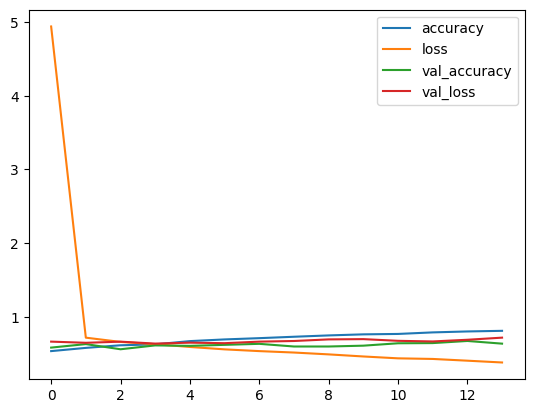

In [105]:
pd.DataFrame(history_11.history).plot()

Al principio la función de pérdida de train es muy alta, baja drásticamente y sigue bajando, la función de pérdida de validación baja un poco al principio, pero después, a medida que sobreajusta va subiendo. Debido al sobreajuste el accuracy de train a subiendo, pero el de validation se mantiene constante.

### **Evaluación**

In [106]:
model_11.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6695 - loss: 0.6257


[0.6619268655776978, 0.6110000014305115]

Tiene un accuracy cercano al 50% es poco mejor que un clasificador aleatorio, necesitaríamos más datos y trabajar más en él para mejorarlo, son muy pocos datos para un modelo de deep learning. Sin embargo, para saber cuáles son las imágenes que peor predice puede ser suficiente.

In [107]:
probabilities = model_11.predict(X_test)
y_pred = np.array([(pred >= 0.5).astype(int) for pred in probabilities]).T[0]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [108]:
y_pred.shape

(1000,)

In [109]:
y_pred[:5]

array([1, 1, 0, 1, 1])

In [110]:
y_test[:5]

array([1, 1, 1, 1, 1])

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.53      0.58       500
           1       0.60      0.69      0.64       500

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.61      1000
weighted avg       0.61      0.61      0.61      1000



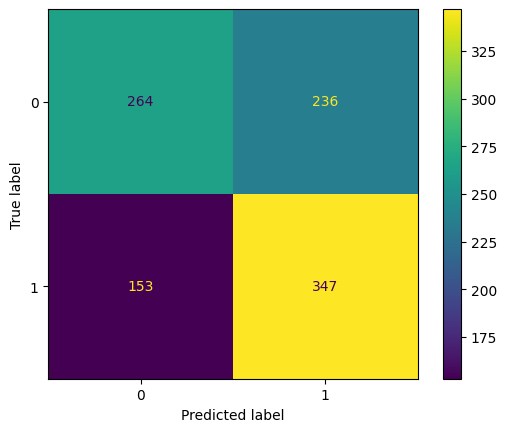

In [112]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, y_pred)

Vemos que no es un clasificador muy bueno y se le escapan bastantes imágenes.

In [127]:
model_12 = tf.keras.Sequential()

model_12.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_12.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_12.add(tf.keras.layers.Conv2D(filters = 80, kernel_size= (3,3), padding = "same", activation = "relu"))
model_12.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_12.add(tf.keras.layers.Dropout(0.25))

model_12.add(tf.keras.layers.Flatten())

model_12.add(tf.keras.layers.Dense(200, activation = "relu"))

model_12.add(tf.keras.layers.Dropout(0.5))

model_12.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
model_12.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [129]:
model_12.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 200)            │     1,024,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,401 (4.02 MB)

 Trainable params: 1,054,401 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history_12 = model_12.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.5181 - loss: 23.9001 - val_accuracy: 0.5675 - val_loss: 0.6786
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5549 - loss: 0.6754 - val_accuracy: 0.5638 - val_loss: 0.6695
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.6271 - loss: 0.6428 - val_accuracy: 0.6162 - val_loss: 0.6473
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6334 - loss: 0.6262 - val_accuracy: 0.5938 - val_loss: 0.6545
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6366 - loss: 0.6103 - val_accuracy: 0.6087 - val_loss: 0.6696
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6530 - loss: 0.5848 - val_accuracy: 0.6000 - val_loss: 0.6606
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.6763 - loss: 0.5773 - val_accuracy: 0.5763 - val_loss: 0.6717
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6966 - loss: 0.54

In [131]:
model_13 = tf.keras.Sequential()

model_13.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_13.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_13.add(tf.keras.layers.Conv2D(filters = 80, kernel_size= (3,3), padding = "same", activation = "relu"))
model_13.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_13.add(tf.keras.layers.Dropout(0.25))

model_13.add(tf.keras.layers.Flatten())

model_13.add(tf.keras.layers.Dense(500, activation = "relu"))

model_13.add(tf.keras.layers.Dropout(0.5))

model_13.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [134]:
model_13.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [135]:
model_13.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 500)            │     2,560,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,001 (9.88 MB)

 Trainable params: 2,591,001 (9.88 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history_13 = model_13.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.5307 - loss: 10.6002 - val_accuracy: 0.5825 - val_loss: 0.6688
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.6111 - loss: 0.6581 - val_accuracy: 0.5875 - val_loss: 0.6799
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.6468 - loss: 0.6147 - val_accuracy: 0.5962 - val_loss: 0.6716
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.6750 - loss: 0.5874 - val_accuracy: 0.5775 - val_loss: 0.6898
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.6943 - loss: 0.5428 - val_accuracy: 0.5813 - val_loss: 0.7472
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.7121 - loss: 0.5195 - val_accuracy: 0.6212 - val_loss: 0.7060
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.7674 - loss: 0.4617 - val_accuracy: 0.6413 - val_loss: 0.7190
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7710 - 

In [137]:
model_13.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5823 - loss: 0.6698


[0.6815474033355713, 0.5989999771118164]

In [138]:
model_14 = tf.keras.Sequential()

model_14.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_14.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_14.add(tf.keras.layers.Conv2D(filters = 80, kernel_size= (3,3), padding = "same", activation = "relu"))
model_14.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_14.add(tf.keras.layers.Dropout(0.25))

model_14.add(tf.keras.layers.Flatten())

model_14.add(tf.keras.layers.Dense(500, activation = "relu"))

model_14.add(tf.keras.layers.Dropout(0.5))

model_14.add(tf.keras.layers.Dense(150, activation = "relu"))

model_14.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [139]:
model_14.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [140]:
model_14.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 500)            │     2,560,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 150)            │        75,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,665,801 (10.17 MB)

 Trainable params: 2,665,801 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history_14 = model_14.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.5092 - loss: 10.3393 - val_accuracy: 0.5600 - val_loss: 0.6841
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.5745 - loss: 0.6779 - val_accuracy: 0.6050 - val_loss: 0.6746
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6111 - loss: 0.6540 - val_accuracy: 0.5813 - val_loss: 0.6634
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.6241 - loss: 0.6182 - val_accuracy: 0.6250 - val_loss: 0.6493
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.6610 - loss: 0.5982 - val_accuracy: 0.5900 - val_loss: 0.7093
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.6395 - loss: 0.6044 - val_accuracy: 0.5838 - val_loss: 0.7097
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6551 - loss: 0.5984 - val_accuracy: 0.6150 - val_loss: 0.7306
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.6902 - 

### **10% de imágenes que peor predice**

In [113]:
probabilities[:10]

array([[0.61273146],
       [0.96640104],
       [0.2584364 ],
       [0.5651401 ],
       [0.5149684 ],
       [0.42454183],
       [0.70705575],
       [0.9004667 ],
       [0.5132005 ],
       [0.64000744]], dtype=float32)

In [114]:
probabilities = probabilities.T[0]

In [115]:
df_prob = pd.DataFrame({"true": y_test, "prediction": y_pred, "prob": probabilities})

In [116]:
cond_1 = df_prob["true"] != df_prob["prediction"]

In [117]:
df_gatos = df_prob.loc[cond_1].sort_values("prob", ascending = True).iloc[: int(round(len(df_prob.loc[cond_1])*0.1, 0))]
df_gatos

,true,prediction,prob
941,1,0,0.090445
53,1,0,0.130990
269,1,0,0.137682
163,1,0,0.141746
203,1,0,0.178454
176,1,0,0.221447
264,1,0,0.243059
76,1,0,0.244895
286,1,0,0.246345
722,1,0,0.252480


In [118]:
df_perros = df_prob.loc[cond_1].sort_values("prob", ascending = False).iloc[: int(round(len(df_prob.loc[cond_1])*0.1, 0))]
df_perros

,true,prediction,prob
987,0,1,0.993885
654,0,1,0.978513
433,0,1,0.971014
439,0,1,0.903750
622,0,1,0.896709
616,0,1,0.884748
655,0,1,0.874329
953,0,1,0.856923
572,0,1,0.843414
908,0,1,0.842203


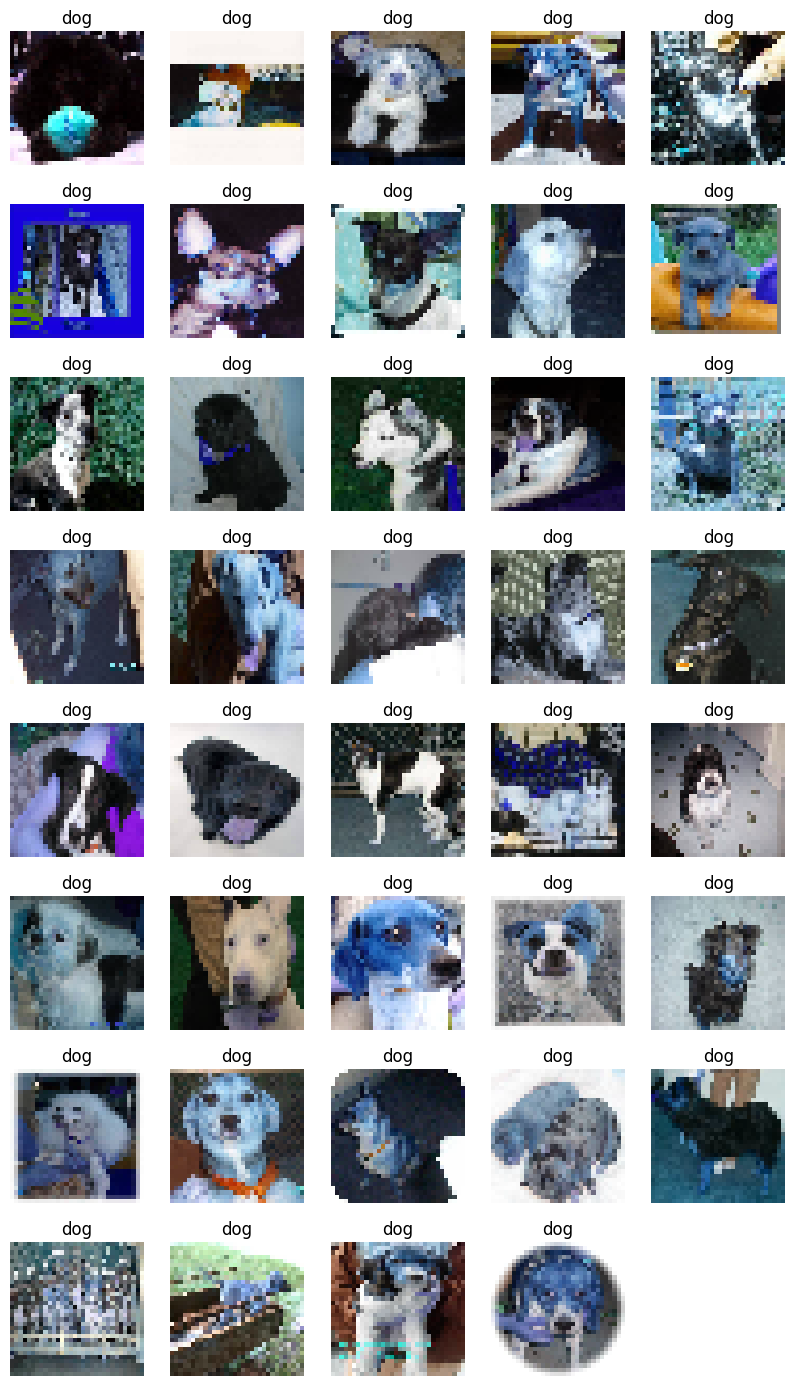

In [119]:
show_images_batch(X_test[df_perros.index.tolist()], 5, y_test[df_perros.index.tolist()])

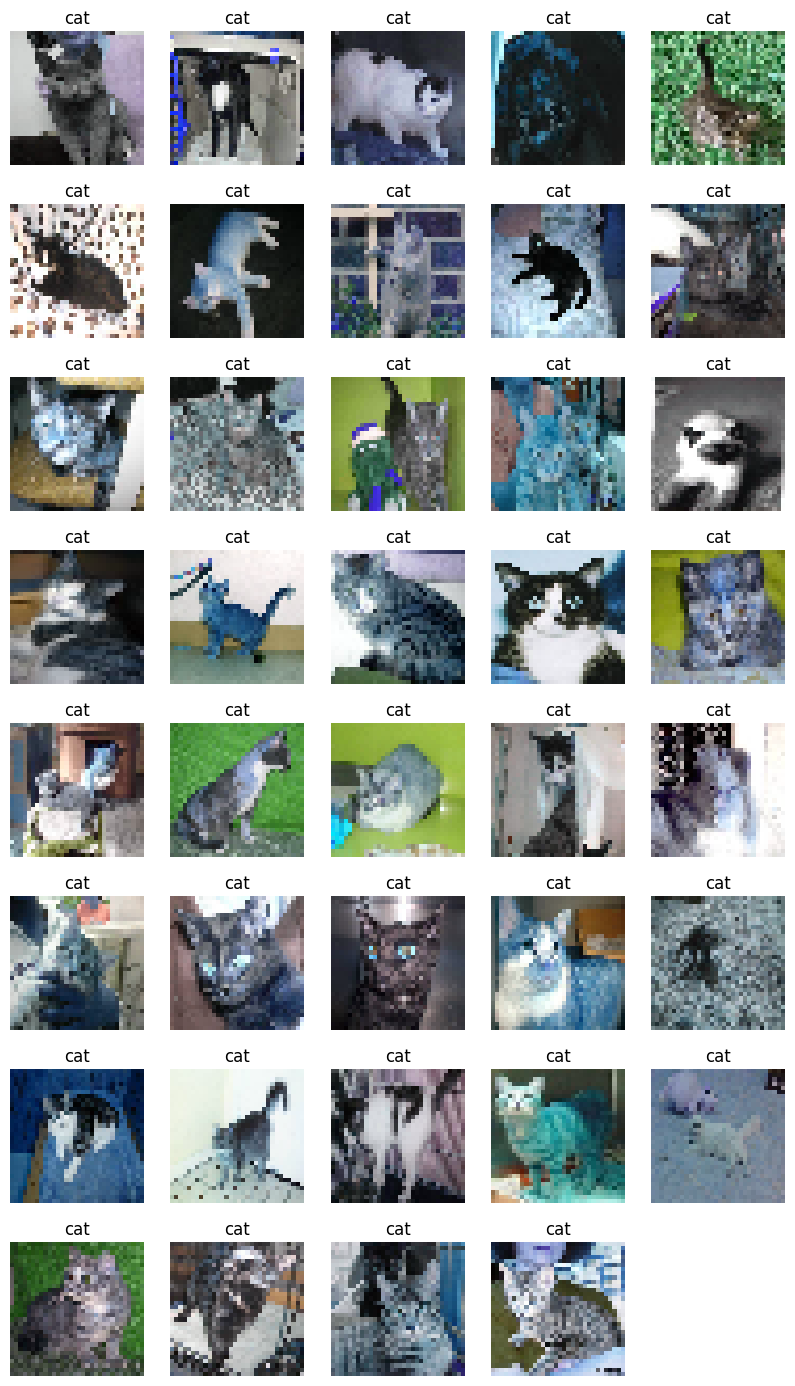

In [120]:
show_images_batch(X_test[df_gatos.index.tolist()], 5, y_test[df_gatos.index.tolist()])